In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
from glob import glob
import random
import pandas as pd 
from tqdm import tqdm
from skimage import measure

In [ ]:
root="./train2/images/" #원본 훈련 데이터셋 루트
all_train_path = sorted(glob("{}*.png".format(root)))
all_mask_path = [p.replace("images","masks") for p in all_train_path]

def getImg(pth):
    img =  cv2.imread(pth)
    msk = cv2.imread(pth,cv2.IMREAD_GRAYSCALE)
    return img,msk

print(len(all_train_path))

### functions

In [ ]:
def getHSV(image):# 녹색, 갈색, 회색, 흰색, 주황색 hsv 마스크 추출
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

	green_mask = cv2.inRange(hsv, (32,23,23), (90,210,210))	
	brown_mask = cv2.inRange(hsv, (74, 74, 74), (255,255,255))
	grey_mask = cv2.inRange(hsv, (0, 10, 00), (180, 30, 255))
	white_mask = cv2.inRange(hsv, (0,0,168), (172,111,255))
	orange_mask = cv2.inRange(hsv,(5, 75, 25), (25, 255, 255))  
	return (green_mask, brown_mask, grey_mask, white_mask, orange_mask)

# 녹지, 길/황무지, 건물 비율 계산
def calc_background_ratio(image,hsv_masks):
	percentage = lambda mask: round(((mask > 0).mean()) * 100,3)
	green_mask1,brown_mask,grey_mask,white_mask,orange_mask = hsv_masks
	roads_barrenlands = round(percentage(brown_mask) + percentage(orange_mask),3)
	greenery = percentage(green_mask1)
	constructions = round(percentage(grey_mask) + percentage(white_mask),3)
	oranges = percentage(orange_mask)
	print("Greenery % - ", greenery," \nRoads/Barren Land % - ",roads_barrenlands," \nConstructions % - ",constructions, " \norange % - ",oranges)
	return (greenery, roads_barrenlands, constructions)

# green hsv 마스크를 통한 녹지 비율 계산
def calc_green_ratio(green_hsv):
	percentage = lambda mask: round(((mask > 0).mean()) * 100,3)
	greenery = percentage(green_hsv)
	return greenery

# 마스크를 읽어 건물 비율 계산
def calc_building_ratio(m):
	mask = cv2.imread(m,cv2.IMREAD_GRAYSCALE)
	total_pixel = mask.size
	num_true = np.count_nonzero(mask == 1)
	ratio = (num_true / total_pixel)*100
	ratio = round(ratio,3)
	return ratio

#그래프의 범위(bin)에 해당하는 데이터 개수 카운트
def count(ratios,cnt,bins):
	cnt = cnt
	for	n in ratios:
		for i,v in enumerate(bins):
			if(n<=v):
				cnt[i]+=1
				break
	return cnt 

In [ ]:
#데이터셋의 건물/녹지 비율 계산
building_ratios = []
green_ratios = []

for i,m in enumerate(tqdm(all_mask_path)):
    building_ratios.append(round(calc_building_ratio(m),3))
    img_pth = m.replace("masks","images")
    img,msk = getImg(img_pth)
    green_hsv = getHSV(img)[0]
    green_ratios.append(calc_green_ratio(green_hsv))

print(len(building_ratios))
print(len(green_ratios))

### 건물/녹지 비율 데이터프레임/CSV 생성

In [ ]:
# 데이터프레임 생성
df = pd.DataFrame(building_ratios,columns=['building'])
df['greenery'] = green_ratios
df['img'] = [n.split("/")[-1] for n in all_mask_path]

In [ ]:
#csv 생성
df.to_csv("./new_csvs/7140_csv.csv")

In [ ]:
# OBA + 이미지 패치 csv 병합
df1 = pd.read_csv("./new_csvs/20000_csv.csv")
df2 = pd.read_csv("./new_csvs/64260_csv.csv")
df = pd.concat([df1, df2], axis=0)

In [ ]:
df = pd.read_csv("./new_csvs/7140_csv.csv") #원본 데이터셋 csv

In [ ]:
df = pd.read_csv("./new_csvs/64260_csv.csv") #이미지패치 데이터셋 csv

In [3]:
df = pd.read_csv("./new_csvs/20000_csv.csv") #OBA 데이터셋 csv

In [4]:
#읽어들인 csv의 class 쪼개기
# class1 : 건물 <=10 & 20<= 녹지 <=80
# class2 : 건물 <=10 & 녹지 <20
# class3 : 건물 <=10 & 80< 녹지
# class4 : 10 < 건물

under_b10_g2080 = df[(df['building']<=10) & (20<=df['greenery']) & (df['greenery']<=80)]
under_b10_g20 = df[(df['building']<=10) & (df['greenery']<20)]
under_b10_g80 = df[(df['building']<=10) & (df['greenery']>80) ]
over_b10 = df[df['building']>10]

### 녹지/건물 비율 원형/막대 그래프

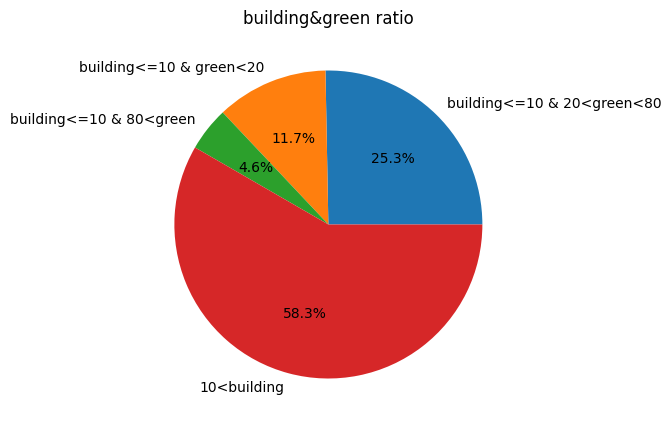

In [5]:
#각 클래스별 비율 원형그래프 출력

counts = [len(under_b10_g2080),len(under_b10_g20),len(under_b10_g80),len(over_b10)]
def plot_list_as_pie_chart(data_list):
    total_count = sum(data_list)

    proportions = [count / total_count for count in data_list]

    labels = ["building<=10 & 20<green<80","building<=10 & green<20","building<=10 & 80<green","10<building"]

    plt.figure(figsize=(10,5))
    plt.rc('font', size=10)  
    plt.pie(proportions, labels=labels, autopct='%1.1f%%')
    plt.title('building&green ratio')

    plt.show()
plot_list_as_pie_chart(counts)

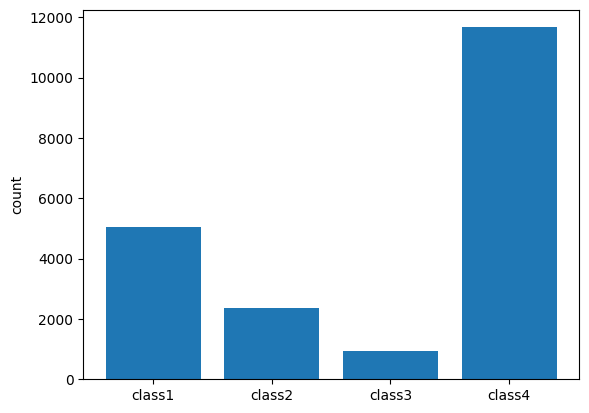

[5060, 2347, 926, 11667]


In [7]:
# 각 클래스별 비율 막대그래프 출력

counts = [len(under_b10_g2080),len(under_b10_g20),len(under_b10_g80),len(over_b10)]
def plot_list_as_graph(data_list):
    x_values = ["class1","class2","class3","class4"] 
    y_values = data_list
    x = np.arange(4)

    plt.bar(x,y_values)
    plt.xticks(x,x_values)
    plt.rc('font', size=10)  
    plt.ylabel('count')
    # plt.title('OBA')  

    plt.show()

plot_list_as_graph(counts)

print(counts)

### 건물 비율 막대그래프 

In [ ]:
#건물 비율(녹지비율 제외) 막대 그래프 출력

counts=[0,0,0,0,0,0,0,0,0,0]
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
counts = count(df['building'],counts,bins)

print(sum(counts),counts)

In [ ]:
def plot_list_as_graph(data_list):
    x_values = [10,20,30,40,50,60,70,80,90,100] 
    y_values = data_list
    x = np.arange(10)

    plt.bar(x,y_values)
    plt.xticks(x,x_values)
    
    plt.xlabel('building ratio') 
    plt.ylabel('count')
    # plt.title(' building ratio')  

    plt.show()

plot_list_as_graph(counts)

### 녹지 비율별 분포

In [ ]:
g10 = (df[df['greenery']<=10])
g20 = (df[(df['greenery']>10) & (df['greenery']<20)])
g30 = (df[(df['greenery']>=20) & (df['greenery']<30)])
g40 = (df[(df['greenery']>=30) & (df['greenery']<40)])
g50 = (df[(df['greenery']>=40) & (df['greenery']<50)])
g60 = (df[(df['greenery']>=50) & (df['greenery']<60)])
g70 = (df[(df['greenery']>=60) & (df['greenery']<70)])
g80 = (df[(df['greenery']>=70) & (df['greenery']<80)])
g90 = (df[(df['greenery']>=80) & (df['greenery']<90)])
g100 = (df[(df['greenery']>=90) & (df['greenery']<100)])


In [ ]:
count_g= [0,0,0,0,0,0,0,0,0,0]
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

count_g = count(df['greenery'],count_g,bins)

In [ ]:
def plot_list_as_graph(data_list):
    x_values = [10,20,30,40,50,60,70,80,90,100]  # 리스트의 인덱스를 x축으로 사용
    y_values = data_list # 리스트의 값(요소)를 y축으로 사용
    x = np.arange(10)

    # plt.plot(x_values, y_values, linestyle='-')
    plt.bar(x,y_values)
    plt.xticks(x,x_values)
    plt.rc('font', size=10)  
    plt.xlabel('greenery ratio') 
    plt.ylabel('count')
    # plt.title('greenery ratio distribution')  
    
    # plt.grid()
    plt.show()

plot_list_as_graph(count_g)
# plot_list_as_graph(patch_count)


In [ ]:
def plot_list_as_pie_chart(data_list):
    total_count = sum(data_list)

    proportions = [count / total_count for count in data_list]

    labels = [i for i in range(10,110,10)]

    plt.figure(figsize=(15,15))
    plt.rc('font', size=20)  
    plt.pie(proportions, labels=labels, autopct='%1.1f%%')
    plt.title('building&green ratio')

    plt.show()
plot_list_as_pie_chart(count_g)